<a href="https://colab.research.google.com/github/najmi050/CE-Ontology/blob/main/KnowledgeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import dill
import yaml
import pickle
import numpy as np
import collections
import string
import copy
from datetime import datetime
import pandas as pd
from yaml import safe_load
from pandas.io.json import json_normalize
from difflib import SequenceMatcher
!pip install rdflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from rdflib import Graph, URIRef, Literal, Namespace, XSD
from rdflib.namespace import RDF, RDFS
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DataSetsfilepath = '/content/drive/MyDrive/session.pkl'
 # Save the session
dill.load_session(DataSetsfilepath)

In [ ]:
tic_desc

In [114]:

g = Graph()

g.namespace_manager.bind('ce', Namespace("https://w3id.org/ce#"), override="False")
ce = Namespace("https://w3id.org/ce#")

## **Event node**

In [ ]:
n=0
for event_ in data['event_id']:
    event = URIRef("https://w3id.org/ce/i/Event/"+str(event_))
    datas_event=data.loc[data['event_id']==event_]
    data_event=datas_event.iloc[0]
    #adding Event node
    g.add((event, RDF.type, ce.Event))
    g.add((event, ce.event_id, Literal(event_, datatype=XSD.integer)))
    g.add((event,ce.created_ts,Literal(data_event['created_ts'],datatype=XSD.dateTime)))
    g.add((event,ce.modified_ts,Literal(data_event['modified_ts'],datatype=XSD.dateTime)))
    g.add((event, ce.name, Literal(data_event['name'], datatype=XSD.string)))
    if(type(data_event['website'])!=float):
        g.add((event, ce.website, Literal(str(data_event['website']), datatype=XSD.string)))
    g.add((event, ce.sort_name, Literal(data_event['sort_name'], datatype=XSD.string)))
    g.add((event, ce.ranking_in_level, Literal(int(data_event['ranking_in_level']), datatype=XSD.integer)))
    g.add((event, ce.ranking_level, Literal(int(data_event['ranking_level']), datatype=XSD.integer)))
    for t in datas_event['start_ts']:
      category = URIRef("https://w3id.org/ce/i/Category/"+str(event_)+"/"+str(t))
      g.add((category, ce.category, Literal(data_event['category'], datatype=XSD.string)))
    g.add((event,ce.hasCategory, category))
    g.add((event, ce.status, Literal(data_event['status'], datatype=XSD.string)))
    #adding Tag node
    tag = URIRef("https://w3id.org/ce/i/Tag/"+str(event_))
    for i in data_event['tags']:
        linkTag=i.replace(' ','')
        #print(i)
        g.add((tag,RDF.type,ce.Tag))
        g.add((tag, ce.tags, Literal(i, datatype=XSD.string)))
    g.add((event,ce.hasTag,tag))
    #adding description node
    if(type(data_event['description'])!=float or type(data_event['type'])!=float):
        description = URIRef("https://w3id.org/ce/i/Description/"+str(event_))
        g.add((description,RDF.type,ce.Description))
        if(type(data_event['description'])!=float):
            g.add((description,ce.descriptions,Literal(data_event['description'], datatype=XSD.string)))
        if(type(data_event['type'])!=float):
            g.add((description,ce.types,Literal(data_event['type'].replace(' ',''), datatype=XSD.string)))
        g.add((event,ce.hasDescription,description))
    n+=1
    print(n)
    #adding schedules node
    
        

In [ ]:
with open("/content/drive/MyDrive/df_new_events","rb") as event_data:
    ScheduleData=pickle.load(event_data)
ScheduleData=ScheduleData[['event_id','schedules']]
ScheduleData

In [ ]:
ScheduleData= ScheduleData.explode('schedules')
nu= ScheduleData['schedules'].apply(pd.Series)
ScheduleData= pd.concat([ScheduleData['event_id'],nu],axis=1)
ScheduleData

## **Schedule Node**

In [ ]:
# filepath = '/Users/najmi/Desktop/Final Dissertation/sessionKnowledgeGraph.pkl'
# dill.dump_session(filepath)
i=0
for ab in zip(ScheduleData['event_id'],ScheduleData['start_ts'],ScheduleData['place_id']):
    event = URIRef("https://w3id.org/ce/i/Event/"+str(ab[0]))
    data_event=ScheduleData.loc[ScheduleData['event_id']==ab[0]]
    data_event= data_event.loc[data_event['start_ts']==ab[1]]
    data_event= data_event.loc[data_event['place_id']==ab[2]]
    schedule= URIRef("https://w3id.org/ce/i/Schedule/"+str(ab[0])+"/"+str(ab[2])+"/"+str(ab[1]))
    g.add((schedule,RDF.type,ce.Schedule))
    g.add((schedule,ce.start_ts,Literal(data_event['start_ts'], datatype=XSD.dateTime)))
    g.add((schedule,ce.end_ts,Literal(data_event['end_ts'], datatype=XSD.dateTime)))
    if(type(data_event['performance_space'])!=float):
        g.add((schedule,ce.performance_space,Literal(data_event['performance_space'], datatype=XSD.string)))
    g.add((event,ce.hasSchedule,schedule))
    #PhoneNumber Node Schedule
    if(len(SchedulePhoneData.loc[SchedulePhoneData['event_id']==ab[0]])>0):
        SchedulePhone=SchedulePhoneData.loc[SchedulePhoneData['event_id']==ab[0]]
        SchedulePhone=SchedulePhone.iloc[0]
    
        phoneNumber=URIRef("https://w3id.org/ce/i/PhoneNumber/Schedule/"+str(ab[0])+"/"+str(ab[2])+"/"+str(ab[1]))
        g.add((phoneNumber,RDF.type,ce.PhoneNumber))
        if(type(SchedulePhoneData['info'])!=float):
            g.add((phoneNumber,ce.info,Literal(SchedulePhone['info'],datatype=XSD.string)))
        g.add((schedule,ce.hasPhoneNumber,phoneNumber))
       
        #PhoneNumer node Events
    if(len(PhoneData_events.loc[PhoneData_events['event_id']==ab[0]])>0):
        phoneDataEvent=PhoneData_events.loc[PhoneData_events['event_id']==ab[0]]
        phoneDataEvent=phoneDataEvent.iloc[0]
    
        phoneNumberEvents=URIRef("https://w3id.org/ce/i/PhoneNumber/Event/"+str(ab[0]))
        g.add((phoneNumberEvents,RDF.type,ce.PhoneNumber))
        if(type(phoneDataEvent['info'])!=float):
            g.add((phoneNumberEvents,ce.info,Literal(phoneDataEvent['info'],datatype=XSD.string)))
        elif(type(phoneDataEvent['box_office'])!=float):
            g.add((phoneNumberEvents,ce.box_office,Literal(phoneDataEvent['box_office'],datatype=XSD.string)))
        g.add((event,ce.hasPhoneNumber,phoneNumberEvents))
        i+=1
        print(i)
        

In [ ]:
data
# filepath = '/Users/najmi/Desktop/Final Dissertation/sessionKnowledgeGraph.pkl'
# dill.load_session(filepath)
a=a.drop_duplicates(subset=['event_id','ts'],keep='first')
a

## **Performance** **Node**

In [ ]:
#adding performance node 
i=0
for ab in zip(a['event_id'],a['ts']):
    data_event= data.loc[data['event_id']==ab[0]]
    data_event= data_event.iloc[0]
    p=a.loc[a['event_id']==ab[0]]
    p=p.loc[p['ts']==ab[1]]
    p=p.iloc[0]
    #print(p)
    schedule= URIRef("https://w3id.org/ce/i/Schedule/"+str(ab[0])+"/"+str(data_event['start_ts']))
    performance= URIRef("https://w3id.org/ce/i/Performance/"+str(ab[0])+"/"+ab[1])
    g.add((performance,RDF.type,ce.Performance))
    g.add((performance,ce.ts,Literal(p['ts'],datatype=XSD.dateTime)))
    g.add((performance,ce.duration,Literal(p['duration'],datatype=XSD.string)))
    g.add((performance,ce.time_unkown,Literal(p['time_unknown'],datatype=XSD.string)))
    g.add((schedule,ce.hasPerformance,performance))
    # print(sum(performance_links['event_id']==ab[0]),'haa')
    if(sum(performance_links['event_id']==ab[0])>0):
        performance_link=performance_links.loc[performance_links['event_id']==ab[0]]
        performance_link=performance_link.iloc[0]
        
        #print(performance_link)
        
        link = URIRef("https://w3id.org/ce/i/link/"+str(ab[0]))
        g.add((link,RDF.type,ce.Link))
        if(type(performance_link['url'])!=float):
            g.add((link,ce.url,Literal(performance_link['url'],datatype=XSD.string)))
        elif(type(performance_link['title'])!=float):
            g.add((link,ce.title,Literal(performance_link['title'],datatype=XSD.string)))
        elif(type(performance_link['type'])!=float):
            g.add((link,ce.type,Literal(performance_link['type'],datatype=XSD.string)))
                      
        g.add((performance,ce.hasLink,link))
        # print("hi")
        
    #adding performance's description
    if(sum(prop_desc['event_id']==ab[0])>0):
        
        op= prop_desc.loc[prop_desc['event_id']==ab[0]]
        #print(op)
        op=op.iloc[0]
        description = URIRef("https://w3id.org/ce/i/PerformanceDescription/"+str(ab[0]))
        g.add((description,RDF.type,ce.Description))
        g.add((description,ce.descriptions,Literal(op['description'], datatype=XSD.string)))
        g.add((performance,ce.hasDescription,description))
    #adding PerformanceProperty Node
    if(sum(c['event_id']==ab[0])>0):
        d=c.loc[c['event_id']==ab[0]]
        d=d.iloc[0]
        performanceProperty= URIRef("https://w3id.org/ce/i/performanceProperty/"+str(ab[0])+"/"+ab[1])
        g.add((performanceProperty,RDF.type,ce.PerformanceProperty))
        
#         print(str(prop)=="performance.sold-out")
#         print(prop)
        if(type(c["performance.sold-out"])!=float):
            g.add((performanceProperty,ce.sold_out,Literal(d["performance.sold-out"],datatype=XSD.boolean)))
        elif(type(c["performance.cancelled"])!=float):
            g.add((performanceProperty,ce.cancelled,Literal(d["performance.cancelled"],datatype=XSD.boolean)))
        elif(type(c["list.hitlisted"])!=float):
            g.add((performance,ce.hit_listed,Literal(d["list.hitlisted"],datatype=XSD.boolean)))
        g.add((performance,ce.hasPropery,performanceProperty))
    
    if(sum(tickets['event_id']==ab[0])>0):
        ticks=tickets.loc[tickets['event_id']==ab[0]]
        ticks=ticks.iloc[0]
        ticket= URIRef("https://w3id.org/ce/i/Ticket/"+str(ab[0])+"/"+ab[1])
        g.add((ticket,RDF.type,ce.Ticket))
        g.add((ticket,ce.type,Literal(ticks['type'],datatype=XSD.string)))
        g.add((ticket,ce.currency,Literal(ticks['currency'],datatype=XSD.string)))
        g.add((ticket,ce.min_price,Literal(ticks['min_price'],datatype=XSD.integer)))
        g.add((ticket,ce.max_price,Literal(ticks['max_price'],datatype=XSD.integer)))
        description= URIRef("https://w3id.org/ce/i/TicketDescription/"+str(ab[0])+"/"+ab[1])
        g.add((description,RDF.type,ce.Description))
        if(sum(tic_desc['event_id']==ab[0])>0):

            desc=tic_desc.loc[tic_desc['event_id']==ab[0]]
            desc=desc.iloc[0]
            #print(desc['description'])
            g.add((description,ce.description,Literal(desc['description'],datatype= XSD.string)))
            g.add((ticket,ce.hasDescription,description))
        g.add((performance,ce.hasTicket,ticket))
        i+=1
        print(i)
            
            
             
        

In [ ]:
# f
# dill.load_session(filepath)




In [ ]:
os.listdir('/content/drive/MyDrive')

# Propery Event node

In [ ]:
#propertyEvent Node
for event in c['event_id']:
    p=a.loc[a['event_id']==event]
    p=p.iloc[0]
    performanceProperty= URIRef("https://w3id.org/ce/i/performanceProperty/"+str(event)+"/"+str(p['ts']))#perfomanceTimeStamp
    prop=c.loc[c['event_id']==event]
    prop=prop.iloc[0]
    
    
    propertyEvent= URIRef("https://w3id.org/ce/i/propertyEvent/"+str(event)+"/"+str(p['ts']))
    g.add((propertyEvent,RDF.type,ce.PropertyEvent))
    print(prop)
    if(type(prop['event.minimum-age'])!=float):
        g.add((propertyEvent,ce.minimum_age,Literal(prop['event.minimum-age'],datatype=XSD.string)))
    if(type(prop['event.support'])!=float):
        g.add((propertyEvent,ce.event_support,Literal(prop['event.support'],datatype=XSD.string)))
    if(type(prop['event.session'])!=float):
        g.add((propertyEvent,ce.event_session,Literal(prop['event.session'],datatype=XSD.string)))
    if(type(prop['event.festival'])!=float):
        g.add((propertyEvent,ce.event_festival,Literal(prop['event.festival'],datatype=XSD.string)))
    g.add((performanceProperty,ce.hasEvent,propertyEvent))
    film= URIRef("https://w3id.org/ce/i/film/"+str(event)+"/"+str(p['ts']))
    #Film node
    g.add((film,RDF.type,ce.Film))
    
    g.add((film,ce._3d,Literal(prop['event.film.3d'],datatype=XSD.boolean)))
    if(type(prop['event.film.subtitled'])!=float):
        g.add((film,ce.subtitled,Literal(prop['event.film.subtitled'],datatype=XSD.boolean)))
    if(type(prop['event.film.parent-and-baby'])!=float):
        g.add((film,ce.parent_and_baby,Literal(prop['event.film.parent-and-baby'],datatype=XSD.boolean)))
    if(type(prop['event.film.senior'])!=float):
        g.add((film,ce.senior,Literal(prop['event.film.senior'],datatype=XSD.boolean)))
    if(type(prop['event.film.over-18s'])!=float):
        g.add((film,ce.over_18s,Literal(prop['event.film.over-18s'],datatype=XSD.boolean)))
    if(type(prop['event.film.autism-friendly'])!=float):
        g.add((film,ce.autism_friendly,Literal(prop['event.film.autism-friendly'],datatype=XSD.boolean)))
    if(type(prop['event.film.premium-screening'])!=float):
        g.add((film,ce.premium_screening,Literal(prop['event.film.premium-screening'],datatype=XSD.boolean)))
    if(type(prop['event.film.imax'])!=float):
        g.add((film,ce.imax,Literal(prop['event.film.imax'],datatype=XSD.boolean)))
    g.add((propertyEvent,ce.hasFilm,film))
    #Theatre node
    theatre= URIRef("https://w3id.org/ce/i/Theatre/"+str(event)+"/"+str(p['ts']))
    g.add((theatre,RDF.type,ce.Theatre))
    if(type(prop['event.theatre.bsl-interpreted'])!=float):
        g.add((theatre,ce.bsl_interpreted,Literal(prop['event.theatre.bsl-interpreted'],datatype=XSD.boolean)))
    if(type(prop['event.theatre.captioned'])!=float):
        g.add((theatre,ce.captioned,Literal(prop['event.theatre.captioned'],datatype=XSD.boolean)))
    g.add((film,ce.hasTheatre,theatre))

In [ ]:
# filepath = '/Users/najmi/Desktop/Final Dissertation/sessionKnowledgeGraph3.pkl'
# dill.dump_session(filepath)

In [ ]:
# data
tickets.columns
PropData.columns

# **Property Node**

In [ ]:
# Property Node
i=0
for aEvent in PropData['event_id']:
    event = URIRef("https://w3id.org/ce/i/Event/"+str(aEvent))
    properties = URIRef("https://w3id.org/ce/i/Property/"+str(aEvent))
    g.add((properties,RDF.type,ce.Properties))
    prop= PropData.loc[PropData['event_id']==aEvent]
    prop=prop.iloc[0]
    if(type(prop['actor'])!= float):
        g.add((properties,ce.actor ,Literal(prop['actor'],datatype=XSD.string)))
    if(type(prop['actor:sample'])!= float):
        g.add((properties,ce.actor_sample ,Literal(prop['actor:sample'],datatype=XSD.string)))
    if(type(prop['affiliate:seatwave'])!= float):
        g.add((properties,ce.affiliate_seatwave ,Literal(prop['affiliate:seatwave'],datatype=XSD.string)))
    if(type(prop['affiliate:getmein'])!= float):
        g.add((properties,ce.affiliate_getmein  ,Literal(prop['affiliate:getmein'],datatype=XSD.string)))
    if(type(prop['cast'])!= float):
        g.add((properties,ce.cast ,Literal(prop['cast'],datatype=XSD.string)))
    if(type(prop['booking_essential'])!= float):
        g.add((properties,ce.booking_essential ,Literal(prop['booking_essential'],datatype=XSD.boolean)))
    if(type(prop['awards:fringe-sustainable-practice:2017 '])!= float):
        g.add((properties,ce.awards_fringe_sustainable_practice2017  ,Literal(prop['awards:fringe-sustainable-practice:2017 '],datatype=XSD.boolean)))
    if(type(prop['awards:fringe-sustainable-practice:2015'])!= float):
        g.add((properties,ce.awards_fringe_sustainable_practice2015   ,Literal(prop['awards:fringe-sustainable-practice:2015'],datatype=XSD.boolean)))
    
    
    
    if(type(prop['director'])!= float):
        g.add((properties,ce.director ,Literal(prop['director'],datatype=XSD.string)))
    if(type(prop['dropin_event'])!= float):
        g.add((properties,ce.dropin_event ,Literal(prop['dropin_event'],datatype=XSD.boolean)))
    if(type(prop['event:demographic'])!= float):
        g.add((properties,ce.demographic ,Literal(prop['event:demographic'],datatype=XSD.string)))
    if(type(prop['event:language'])!= float):
        g.add((properties,ce.language ,Literal(prop['event:language'],datatype=XSD.string)))
        print(prop['event:language'])
    if(type(prop['expected_visit_duration'])!= float):
        g.add((properties,ce.expected_visit_duration   ,Literal(prop['expected_visit_duration'],datatype=XSD.string)))
    if(type(prop['film:amg_id'])!= float):
        g.add((properties,ce.film_amg_id  ,Literal(prop['film:amg_id'],datatype=XSD.string)))
    if(type(prop['film:certificate'])!= float):
        g.add((properties,ce.film_certificate ,Literal(prop['film:certificate'],datatype=XSD.string)))
    if(type(prop['film:certificate:bbfc'])!= float):
        g.add((properties,ce.film_certificate_bbfc   ,Literal(prop['film:certificate:bbfc'],datatype=XSD.string)))
    if(type(prop['film:colour'])!= float):
        g.add((properties,ce.film_colour   ,Literal(prop['film:colour'],datatype=XSD.string)))
    
    if(type(prop['film:country-of-origin'])!= float):
        g.add((properties,ce.film_country_of_origin ,Literal(prop['film:country-of-origin'],datatype=XSD.string)))
    if(type(prop['film:imdb'])!= float):
        g.add((properties,ce.film_imdb ,Literal(prop['film:imdb'],datatype=XSD.string)))
    if(type(prop['film:imdb_id'])!= float):
        g.add((properties,ce.film_imdb_id  ,Literal(prop['film:imdb_id'],datatype=XSD.string)))
    if(type(prop['film:itunes'])!= float):
        g.add((properties,ce.film_itunes   ,Literal(prop['film:itunes'],datatype=XSD.string)))
    if(type(prop['film:metacritic'])!= float):
        g.add((properties,ce.film_metacritic  ,Literal(prop['film:metacritic'],datatype=XSD.string)))
    if(type(prop['film:metcritic'])!= float):
        g.add((properties,ce.film_metcritic ,Literal(prop['film:metcritic'],datatype=XSD.string)))
    if(type(prop['film:mojo_id'])!= float):
        g.add((properties,ce.film_mojo_id   ,Literal(prop['film:mojo_id'],datatype=XSD.string)))
    if(type(prop['film:release-date:uk'])!= float):
        g.add((properties,ce.film_release_date_uk   ,Literal(prop['film:release-date:uk'],datatype=XSD.string)))
    
    
    if(type(prop['film:rotten-tomatoes'])!= float):
        g.add((properties,ce.film_rotten_tomatoes ,Literal(prop['film:rotten-tomatoes'],datatype=XSD.string)))
    if(type(prop['film:rotten_tomatoes_id'])!= float):
        g.add((properties,ce.film_rotten_tomatoes_id ,Literal(prop['film:rotten_tomatoes_id'],datatype=XSD.string)))
    if(type(prop['film:running-time'])!= float):
        g.add((properties,ce.film_running_time  ,Literal(prop['film:running-time'],datatype=XSD.string)))
    if(type(prop['film:subtitle'])!= float):
        g.add((properties,ce.film_subtitle   ,Literal(prop['film:subtitle'],datatype=XSD.string)))
    if(type(prop['film:wikipedia'])!= float):
        g.add((properties,ce.film_wikipedia  ,Literal(prop['film:wikipedia'],datatype=XSD.string)))
    if(type(prop['film:wikipedia:image'])!= float):
        g.add((properties,ce.film_wikipedia_image ,Literal(prop['film:wikipedia:image'],datatype=XSD.string)))
    if(type(prop['film:wikipedia:image_caption'])!= float):
        g.add((properties,ce.film_wikipedia_image_caption  ,Literal(prop['film:wikipedia:image_caption'],datatype=XSD.string)))
    if(type(prop['film:year'])!= float):
        g.add((properties,ce.film_year  ,Literal(prop['film:year'],datatype=XSD.string)))
    if(type(prop['writer'])!= float):
        g.add((properties,ce.writer  ,Literal(prop['writer'],datatype=XSD.string)))
    
    if(type(prop['list:feed:imageid'])!= float):
        g.add((properties,ce.imageid ,Literal(prop['list:feed:imageid'],datatype=XSD.string)))
    if(type(prop['list:importanceOverride'])!= float):
        g.add((properties,ce.importanceOverride ,Literal(prop['list:importanceOverride'],datatype=XSD.string)))
    if(type(prop['list:importance'])!= float):
        g.add((properties,ce.importance ,Literal(prop['list:importance'],datatype=XSD.string)))
    if(type(prop['list:sportscotland:include'])!= float):
        g.add((properties,ce.list_sportscotland_include  ,Literal(prop['list:sportscotland:include'],datatype=XSD.string)))
    if(type(prop['list:website:comments-enabled'])!= float):
        g.add((properties,ce.website_comments_enabled   ,Literal(prop['list:website:comments-enabled'],datatype=XSD.boolean)))
    if(type(prop['list:website:comments-end-date'])!= float):
        g.add((properties,ce.website_comments_end_date  ,Literal(prop['list:website:comments-end-date'],datatype=XSD.string)))
    if(type(prop['list:website:company'])!= float):
        g.add((properties,ce.website_company ,Literal(prop['list:website:company'],datatype=XSD.string)))
    if(type(prop['list:website:hitlisted'])!= float):
        g.add((properties,ce.website_hitlisted   ,Literal(prop['list:website:hitlisted'],datatype=XSD.string)))
    if(type(prop['list:website:list-of-sites'])!= float):
        g.add((properties,ce.website_list_of_sites   ,Literal(prop['list:website:list-of-sites'],datatype=XSD.string)))
    
    if(type(prop['organisation'])!= float):
        g.add((properties,ce.organisation  ,Literal(prop['organisation'],datatype=XSD.string)))
    if(type(prop['pa:rating'])!= float):
        g.add((properties,ce.pa_rating ,Literal(prop['pa:rating'],datatype=XSD.string)))
    if(type(prop['place:capacity:max'])!= float):
        g.add((properties,ce.capacity_max   ,Literal(prop['place:capacity:max'],datatype=XSD.string)))
    if(type(prop['simpleview:original:categories'])!= float):
        g.add((properties,ce.simpleview_original_categories   ,Literal(prop['simpleview:original:categories'],datatype=XSD.string)))
    g.add((event,ce.hasProperty,properties))
    i+=1
    print('end of loop',i)

In [ ]:
# DataSetsfilepath = '/Users/najmi/Desktop/Final Dissertation/session.pkl'
#  # Save the session
# dill.load_session(DataSetsfilepath)
#data=data.drop(['descriptions','id','performances'],axis=1)
# filepath = '/Users/najmi/Desktop/Final Dissertation/sessionKnowledgeGraph3.pkl'
# dill.load_session(filepath)
# !pip install pygpu
# import pygpu
# filepath = '/content/drive/MyDrive/sessionKnowledgeGraph4.pkl'
# dill.load_session(filepath)

# ![dataModel.png](attachment:dataModel.png)

In [ ]:
with open("/content/df_places","rb") as places_data:
    placesData=pickle.load(places_data)

In [ ]:
locData=loc
locData.drop_duplicates(keep='first')

# **Place Node**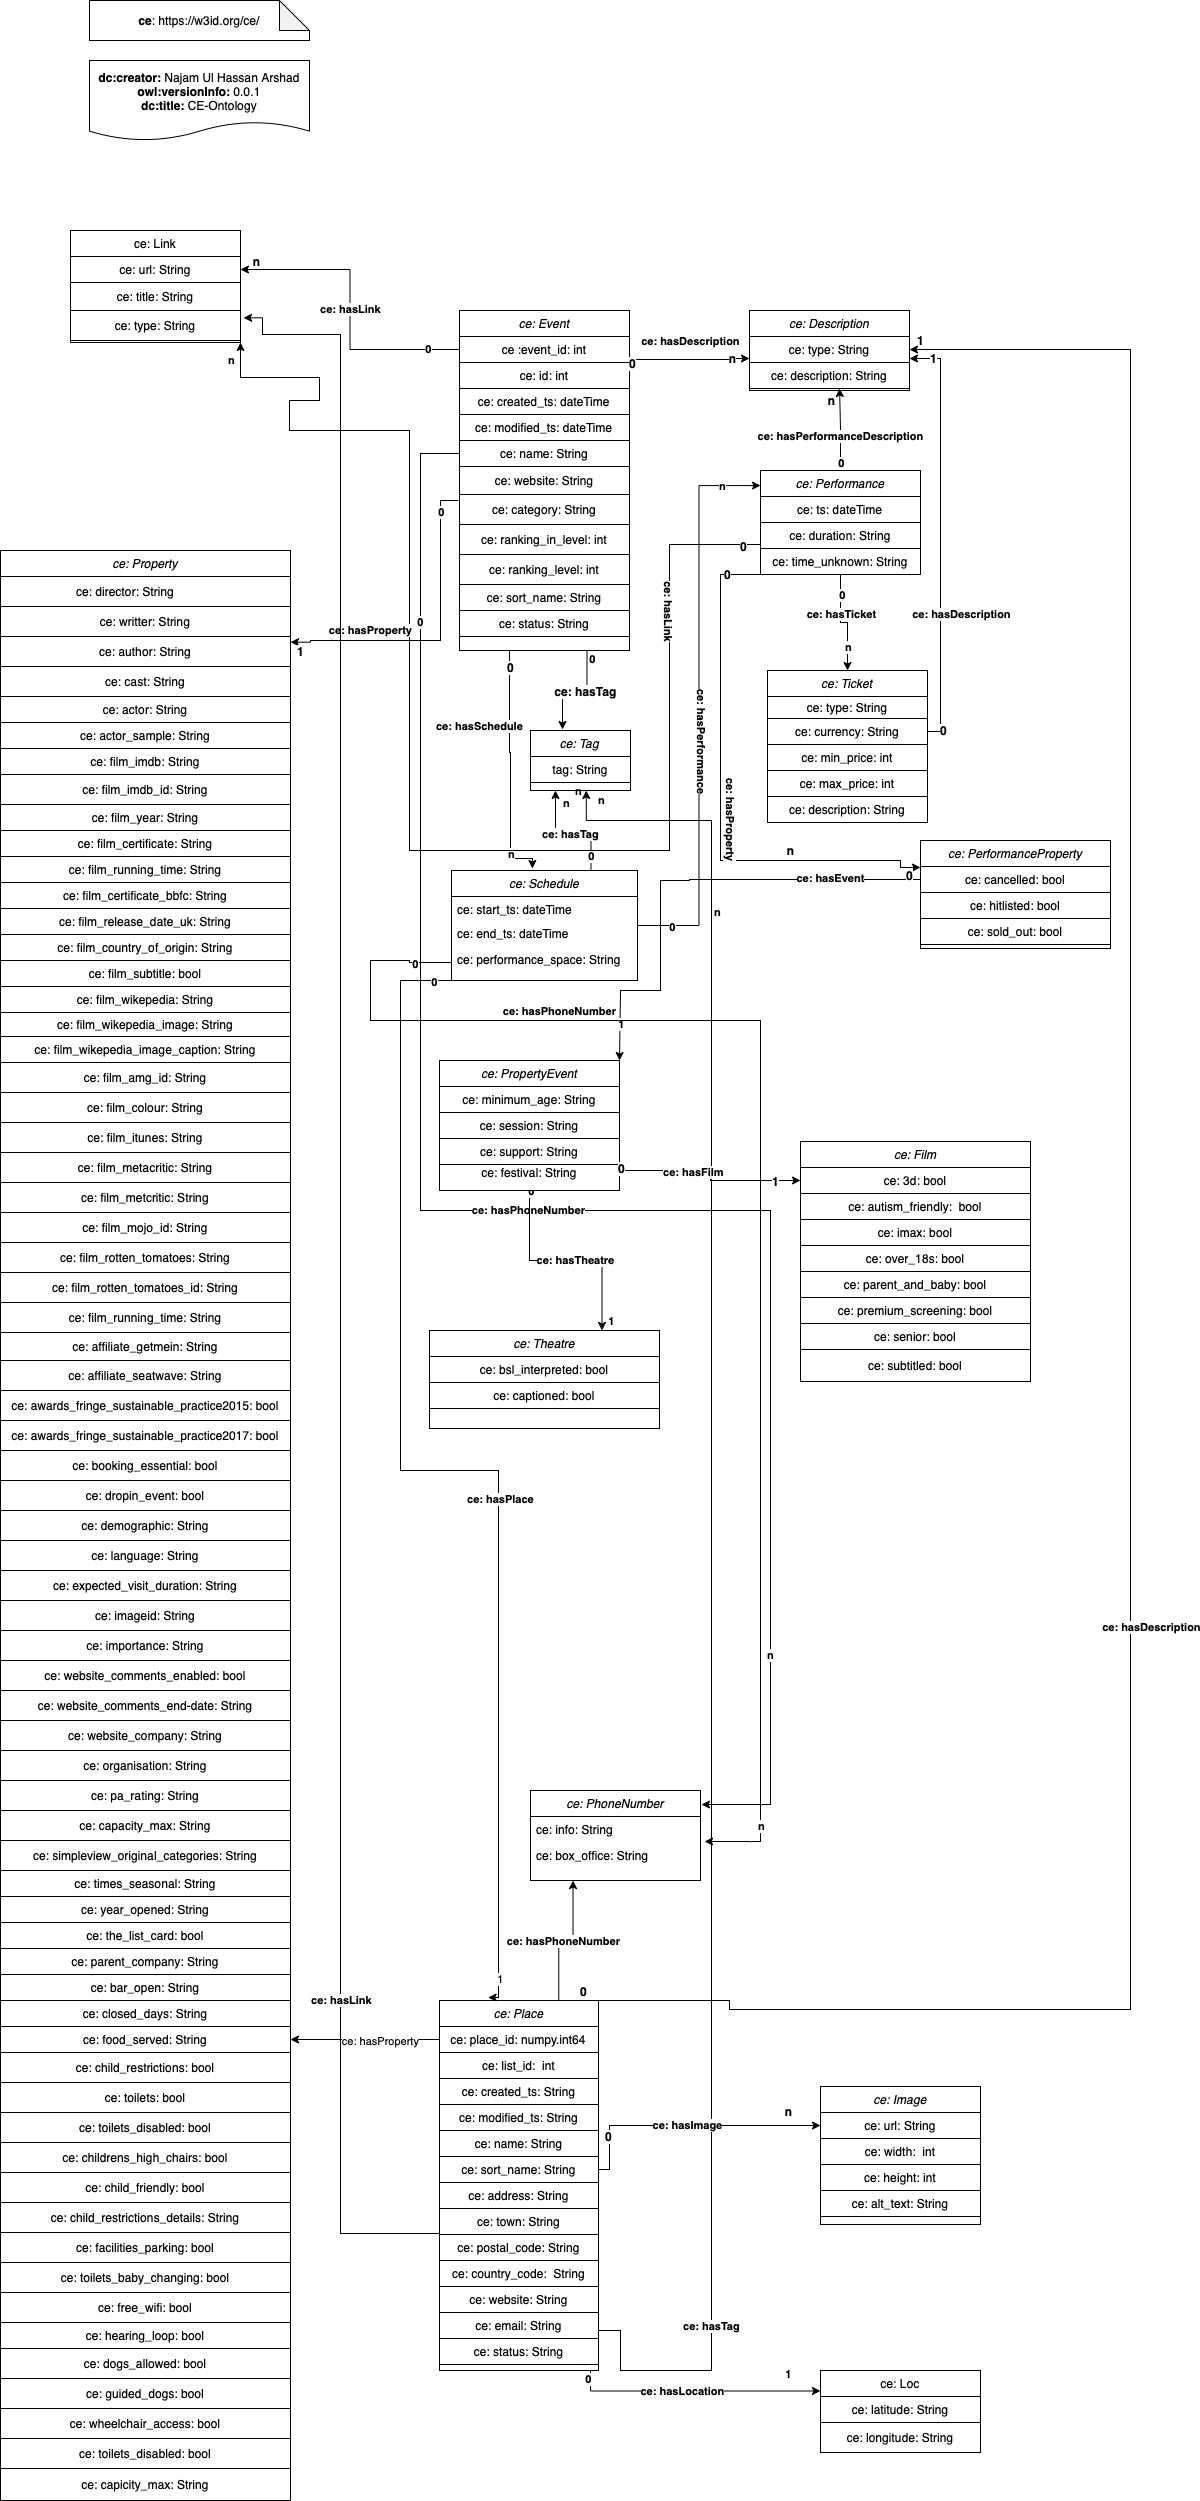

In [ ]:
#ce:place node
for event_ in data['event_id']:
    eventData= data.loc[data['event_id']==event_]
    
    places=pd.unique(eventData['place_id'])
    eventData= eventData.iloc[0]
    for place_id in places:
      
      placeData= placesData.loc[placesData['place_id']==place_id]
      placeData= placeData.iloc[0]
      event = URIRef("https://w3id.org/ce/i/Event/"+str(event_))
      place = URIRef("https://w3id.org/ce/i/Place/"+str(place_id))
      g.add((place,RDF.type,ce.Place))
      g.add((place,ce.place_id,Literal(place_id,datatype=XSD.integer)))
      g.add((place,ce.created_ts,Literal(str(placeData['created_ts']),datatype=XSD.string)))
      g.add((place,ce.modified_ts,Literal(str(placeData['modified_ts']),datatype=XSD.string)))
      g.add((place,ce.name,Literal(placeData['name'],datatype=XSD.string)))
      g.add((place,ce.sort_name,Literal(placeData['sort_name'],datatype=XSD.string)))
      if(type(placesData['address'])!=float):
          g.add((place,ce.address,Literal(placeData['address'],datatype=XSD.string)))
      if(type(placesData['town'])!=float):
          g.add((place,ce.town,Literal(placeData['town'],datatype=XSD.string)))
      g.add((place,ce.postal_code,Literal(placeData['postal_code'],datatype=XSD.string)))
      g.add((place,ce.country_code,Literal(placeData['country_code'],datatype=XSD.string)))
      if(type(placesData['website'])!=float):
          g.add((place,ce.website,Literal(placeData['website'],datatype=XSD.string)))
      if(type(placesData['email'])!=float):
          g.add((place,ce.email,Literal(placeData['email'],datatype=XSD.string)))
      g.add((place,ce.status,Literal(placeData['status'],datatype=XSD.string)))
      # adding location node
      location=locData.loc[locData['place_id']==place_id]
      location= location.iloc[0]
      loc = URIRef("https://w3id.org/ce/i/Location/"+str(place_id))
      g.add((loc,RDF.type,ce.Loc))
      g.add((loc,ce.longitude,Literal(str(location['longitude']),datatype=XSD.string)))
      g.add((loc,ce.latitude,Literal(str(location['latitude']),datatype=XSD.string)))
      g.add((place,ce.hasLocation,loc))
      #adding tag node
      if(len(placeTags.loc[placeTags['place_id']==place_id,'tags'])>0):
          thisTag= placeTags.loc[placeTags['place_id']==place_id,'tags']
          thisTag= thisTag.iloc[0]
          if(type(thisTag)!=float):
              tag = URIRef("https://w3id.org/ce/i/placeTag/"+str(place_id))
              g.add((tag,RDF.type,ce.Tag))
              for aTag in thisTag:
                  g.add((tag,ce.Tags,Literal(str(aTag),datatype=XSD.string)))
                  print(aTag,'ha',linkTag)
              g.add((place,ce.hasTag,tag))
      
      #adding place properties' node
      if(len(place_prop.loc[place_prop['place_id']==place_id])>0):
          thisPlaceProps=place_prop.loc[place_prop['place_id']==place_id]
          thisPlaceProps= thisPlaceProps.iloc[0]
          properties = URIRef("https://w3id.org/ce/i/Property/"+str(place_id))
          g.add((properties,RDF.type,ce.Property))
          if(type(thisPlaceProps['place.capacity.max'])!=float):
              g.add((properties,ce.capacity_max,Literal(str(thisPlaceProps['place.capacity.max']),datatype=XSD.string)))
          if(type(thisPlaceProps['place.child-friendly'])!=float):
              g.add((place,ce.child_friendly,Literal(str(thisPlaceProps['place.child-friendly']),datatype=XSD.string)))
          if(type(thisPlaceProps['place.child-restrictions'])!=float):
              g.add((properties,ce.child_restrictions ,Literal(thisPlaceProps['place.child-restrictions'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.dogs-allowed'])!=float):
              g.add((properties,ce.dogs_allowed ,Literal(thisPlaceProps['place.facilities.dogs-allowed'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.free-wifi'])!=float):
              g.add((properties,ce.free_wifi ,Literal(thisPlaceProps['place.facilities.free-wifi'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.guide-dogs'])!=float):
              g.add((properties,ce.guide_dogs ,Literal(thisPlaceProps['place.facilities.guide-dogs'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.hearing-loop'])!=float):
              g.add((properties,ce.hearing_loop ,Literal(thisPlaceProps['place.facilities.hearing-loop'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.parking'])!=float):
              g.add((properties,ce.free_wifi ,Literal(thisPlaceProps['place.facilities.parking'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.toilets'])!=float):
              g.add((properties,ce.toilets ,Literal(thisPlaceProps['place.facilities.toilets'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.toilets.baby-changing'])!=float):
              g.add((properties,ce.baby_changing ,Literal(thisPlaceProps['place.facilities.toilets.baby-changing'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.toilets_disabled'])!=float):
              g.add((properties,ce.toilets_disabled  ,Literal(thisPlaceProps['place.facilities.toilets_disabled'],datatype=XSD.boolean)))
          if(type(thisPlaceProps['place.facilities.wheelchair-access'])!=float):
              g.add((properties,ce.wheelchair_access ,Literal(thisPlaceProps['place.facilities.wheelchair-access'],datatype=XSD.boolean)))
      
          g.add((place,ce.hasProperty,properties))
      #adding phone node
          phone=placesPhoneData.loc[placesPhoneData['place_id']==place_id]
          phone= phone.iloc[0]
          phoneNumber= URIRef("https://w3id.org/ce/i/PhoneNumber/"+str(place_id))
          if(type(phone['info'])!= float):
              g.add((phoneNumber,ce.info ,Literal(phone['info'],datatype=XSD.string)))
          if(type(phone['box_office'])!= float):
              g.add((phoneNumber,ce.box_office ,Literal(phone['box_office'],datatype=XSD.string)))
      
          g.add((place,ce.hasPhoneNumber, phoneNumber))
      # adding description node
          description= URIRef("https://w3id.org/ce/i/placeDescription/"+str(place_id))
          g.add((description, RDF.type, ce.Description))
          if(len( placeDesc.loc[placeDesc['place_id']==place_id])>0):
              place_description=placeDesc.loc[placeDesc['place_id']==place_id]
              place_description= place_description.iloc[0]
              print(place_description)
              if(type(place_description['description'])!=float):
                  g.add((description,ce.description,Literal(place_description['description'],datatype=XSD.string)))
              if(type(place_description['type'])!=float):
                  g.add((description,ce.type ,Literal(str(place_description['type']),datatype=XSD.string)))
              g.add((place,ce.hasDescription,description))
          
              
          
      
      g.add((event,ce.hasPlace,place))
          
        
        
#     print(location)
#     print(place)
#     print(event_)
   
    
    
    
    
    
    

In [265]:
filepath = '/content/drive/MyDrive/sessionKnowledgeGraph4.pkl'
dill.dump_session(filepath)

In [123]:
# filepath = '/content/drive/MyDrive/sessionKnowledgeGraph4.pkl'
# dill.load_session(filepath)

/usr/local/lib/python3.7/dist-packages/rdflib/term.py:1439: UserWarning: Parsing weird boolean, 'nan' does not map to True or False
  category=UserWarning,


# SPARQL CHECKING

In [3]:
# #data=data.drop_duplicates(subset=['event_id','modified_ts','created_ts',
#                     'name',         'sort_name',            'status',
#                  'website','category',
#                    'ranking_level',  'ranking_in_level','frequency_event' ,
#                 'start_ts',            'end_ts',          'place_id'])
!pip install SPARQLWrapper
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as pl
from rdflib import Graph, ConjunctiveGraph, Namespace, Literal
from rdflib.plugins.sparql import prepareQuery
import networkx as nx
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
ce = Namespace("https://w3id.org/ce#")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 482 kB 6.7 MB/s 
     |████████████████████████████████| 41 kB 870 kB/s 


In [ ]:

# phone=placesPhoneData.loc[placesPhoneData['place_id']==383]
# phone= phone.iloc[0]
# phone


In [ ]:
# q3 = prepareQuery('''
# SELECT ?b  ?k

#     WHERE {
#       ?event ce:hasPerformance ?performance.
#      ?performance ce:hasDescription ?k.
#      ?k ce:descriptions ?b.
#        }
#        limit 10
#     ''',
#   initNs = { "ce": ce}
# )

In [224]:
# for r in g.query(q3):
#     print(" ",r.k,r.b)
# placesData.columns
q4 = prepareQuery('''
SELECT (count(distinct ?per) as ?Total)

    WHERE {
      ?e ce:event_id ?per.
      
       }
    
    ''',
  initNs = { "ce": ce}
)

In [225]:
for r in g.query(q4):
    print("ce:hasEvnt ",r.Total)

ce:hasEvnt  38700


In [221]:
q3 = prepareQuery('''
SELECT (count(distinct ?per) as ?Total)

    WHERE {
      ?e ce:hasSchedule ?per.
      
       }
    
    ''',
  initNs = { "ce": ce}
)

In [222]:
for r in g.query(q3):
    print("ce:hasEvnt ",r.Total)

ce:hasEvnt  48790


In [219]:
q4 = prepareQuery('''
SELECT (count(distinct ?per) as ?TotalPer)

    WHERE {
      ?e ce:hasPerformance ?per.
      
       }
    
    ''',
  initNs = { "ce": ce}
)

# eb=tic_desc.loc[tic_desc['event_id']==156630]
# eb
# filepath = '/Users/najmi/Desktop/Final Dissertation/sessionKnowledgeGraph4.pkl'
# dill.load_session(filepath)

In [220]:
for r in g.query(q4):
    print("ce:hasEvnt ",r.TotalPer)

ce:hasEvnt  349855


In [278]:
q5 = prepareQuery('''
SELECT (count(?sceds) as ?totalCityEvents)

    WHERE {
      
     ?events ce:category ?cat;
      ce:hasSchedule ?sceds;
      ce:hasPlace ?place.
      ?place ce:town ?town.

       }
       
    
    ''',
  initNs = { "ce": ce}
)

# eb=tic_desc.loc[tic_desc['event_id']==156630]
# eb
# filepath = '/Users/najmi/Desktop/Final Dissertation/sessionKnowledgeGraph4.pkl'
# dill.load_session(filepath)

In [279]:
for r in g.query(q5,initBindings = {'?cat' : Literal('Music', datatype=XSD.string),'?town' : Literal('Edinburgh', datatype=XSD.string)}):
  print(r.totalCityEvents)

0


In [218]:
data[data['category']=='Music'].drop_duplicates(subset=['event_id','category','start_ts'],keep='first')

,event_id,modified_ts,created_ts,name,sort_name,status,id,descriptions,website,tags,...,alternative_names,start_ts,end_ts,place_id,performances,performance_space,phone_numbers,0,description,type
0,157884,2021-01-13T18:46:26Z,2007-12-06T17:18:12Z,Väsen,Väsen,live,157884,"[{'type': 'description.list.default', 'descrip...",http://www.twoforjoy.co.uk,"[Folk, Music]",...,NaN,2018-04-26T20:00:00+01:00,2018-04-26T20:00:00+01:00,383,"[{'ts': '2018-04-26T20:00:00+01:00', 'duration...",NaN,NaN,NaN,Swedish trio combining acoustic instrumentatio...,description.list.default
1,194419,2022-02-02T01:03:54Z,2010-01-25T14:51:46Z,Martin Simpson,Martin Simpson,live,194419,"[{'type': 'description.list.default', 'descrip...",http://www.martinsimpson.com/,"[Blues, Folk & world, Folk, Music, Jazz]",...,NaN,2018-03-10T19:30:00+00:00,2018-03-10T19:30:00+00:00,11092,"[{'ts': '2018-03-10T19:30:00+00:00', 'duration...",NaN,NaN,NaN,Brilliant mix of English tradition and America...,description.list.default
7,194419,2022-02-02T01:03:54Z,2010-01-25T14:51:46Z,Martin Simpson,Martin Simpson,live,194419,"[{'type': 'description.list.default', 'descrip...",http://www.martinsimpson.com/,"[Blues, Folk & world, Folk, Music, Jazz]",...,NaN,2018-03-08T20:00:00+00:00,2018-03-08T20:00:00+00:00,11200,"[{'ts': '2018-03-08T20:00:00+00:00', 'links': ...",NaN,NaN,NaN,Brilliant mix of English tradition and America...,description.list.default
13,194419,2022-02-02T01:03:54Z,2010-01-25T14:51:46Z,Martin Simpson,Martin Simpson,live,194419,"[{'type': 'description.list.default', 'descrip...",http://www.martinsimpson.com/,"[Blues, Folk & world, Folk, Music, Jazz]",...,NaN,2018-05-07T20:00:00+01:00,2018-05-07T20:00:00+01:00,386,"[{'ts': '2018-05-07T20:00:00+01:00', 'links': ...",NaN,NaN,NaN,Brilliant mix of English tradition and America...,description.list.default
1339,58304,2022-02-03T05:21:16Z,2003-10-06T00:00:00Z,Classic Clapton,Classic Clapton,live,58304,"[{'type': 'description.list.default', 'descrip...",http://www.classic-clapton.com,"[Blues, Rock & Pop, Music, Tribute Act, Eric C...",...,NaN,2018-04-29T19:30:00+01:00,2018-04-29T19:30:00+01:00,610,"[{'ts': '2018-04-29T19:30:00+01:00', 'links': ...",NaN,{'info': '01506 777666'},NaN,A recreation of Clapton's stage show and great...,description.list.default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160540,1551160,2020-03-20T12:22:33Z,2020-03-20T12:22:33Z,Langtoun Jazz Festival 2020 Concert 7 Mike Rog...,Langtoun Jazz Festival 2020 Concert 7 Mike Rog...,live,1551160,"[{'type': 'description.official', 'description...",NaN,"[Jazz, Music]",...,NaN,2020-06-27T15:00:00+01:00,2020-06-27T15:00:00+01:00,122937,"[{'ts': '2020-06-27T15:00:00+01:00', 'duration...",NaN,NaN,NaN,Mike Rogers and his all star trio take well kn...,description.official
160542,1551161,2020-03-20T12:22:37Z,2020-03-20T12:22:37Z,Langtoun Jazz Festival 2020 Concert 8 Marianne...,Langtoun Jazz Festival 2020 Concert 8 Marianne...,live,1551161,"[{'type': 'description.official', 'description...",NaN,"[Jazz, Music]",...,NaN,2020-06-27T16:30:00+01:00,2020-06-27T16:30:00+01:00,122937,"[{'ts': '2020-06-27T16:30:00+01:00', 'duration...",NaN,NaN,NaN,"Marianne McGregor is a mulit-award winning, in...",description.official
160544,1555573,2020-03-20T12:22:42Z,2020-03-20T12:22:42Z,Langtoun Jazz Festival 2020 Concert 9 Sue McHu...,Langtoun Jazz Festival 2020 Concert 9 Sue McHu...,live,1555573,"[{'type': 'description.official', 'description...",NaN,"[Jazz, Music]",...,NaN,2020-06-27T18:00:00+01:00,2020-06-27T18:00:00+01:00,122937,"[{'ts': '2020-06-27T18:00:00+01:00', 'duration...",NaN,NaN,NaN,Sue McHugh and her fine band of Scottish music...,description.official
160556,1596878,2020-09-13T02:21:13Z,2020-09-13T02:21:13Z,"The Secret Garden Sessions With A Maxwell, Lou...","Secret Garden Sessions With A Maxwell, Lou Mcl...",live,1596878,"[{'type': 'description.official', 'description...",NaN,[Music],...,NaN,2020-09-20T15:15:00+01:00,2020-09-20T15:1

In [130]:
for place_id in placesData['place_id']:
  place= URIRef("https://w3id.org/ce/i/Place/"+str(place_id))
  g.remove((place,None,None))

In [156]:
nb=placesData[placesData['town']=='North Berwick']['place_id']

In [ ]:
placesData[placesData['town']=='North Berwick']['place_id']

In [212]:
for event_ in data['event_id']:
  event = URIRef("https://w3id.org/ce/i/Event/"+str(event_))
  g.remove((event,None,None))